<a href="https://colab.research.google.com/github/haritraman/Speech-Emotion-Recognition-SER-/blob/main/tess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Run this cell only ONCE per session ---

# 1. Install Dependencies
print("Installing the required 'resampy' library...")
!pip install -q resampy
print("✅ Installation complete.")

# 2. Import Libraries
import os
import zipfile
import librosa
import numpy as np
import time
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# 3. Mount Google Drive
print("\nMounting Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
    print("✅ Drive mounted successfully.")
except Exception as e:
    print(f"🚨 Error mounting drive: {e}")
    raise

# 4. Unzip the Dataset
# 🔴 IMPORTANT: Update this path to where your archive.zip is located in Google Drive
zip_file_path = '/content/drive/MyDrive/SER_Project/datasets/tess'
extract_dir = '/content/drive/MyDrive/SER_Project/datasets/tess'

print(f"\nUnzipping '{zip_file_path}'...")
if not os.path.exists(extract_dir):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("✅ Unzipping complete.")
    except FileNotFoundError:
        print(f"🚨 ERROR: The file '{zip_file_path}' was not found.")
        print("Please make sure you have uploaded archive.zip and the path is correct.")
        raise
else:
    print("✅ Dataset already unzipped.")

# 5. Find the Correct Data Path for TESS
def find_dataset_folder(base_path):
    for dirpath, dirnames, filenames in os.walk(base_path):
        # For TESS, just check for presence of wav files
        if any(fname.endswith('.wav') for fname in filenames):
            print(f"✅ TESS dataset folder found at: {dirpath}")
            return dirpath
    return None

DATA_PATH = find_dataset_folder(extract_dir)
if DATA_PATH is None:
    print("🚨 ERROR: Could not automatically locate the TESS dataset folder after unzipping.")
    raise FileNotFoundError("Dataset folder not found.")


Installing the required 'resampy' library...
✅ Installation complete.

Mounting Google Drive...
Mounted at /content/drive
✅ Drive mounted successfully.

Unzipping '/content/drive/MyDrive/SER_Project/datasets/tess'...
✅ Dataset already unzipped.
✅ TESS dataset folder found at: /content/drive/MyDrive/SER_Project/datasets/tess


In [ ]:
# --- Run this cell to load, augment, and prepare your data ---

# 1. Install augmentation library
print("Installing 'audiomentations' library...")
!pip install -q audiomentations
print("✅ Installation complete.")
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import tqdm # Import tqdm for the progress bar

# 2. Define the Augmentation Pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

# 3. Load Raw Audio Waves and Labels (TESS-specific)
def load_raw_data(data_path):
    raw_data = []
    labels = []
    start_time = time.time()
    print("\nLoading raw audio files...")
    global initial_sample_rate
    initial_sample_rate = None

    all_files = []
    for file_name in sorted(os.listdir(data_path)):
        if file_name.endswith('.wav'):
            all_files.append(os.path.join(data_path, file_name))

    for file_path in tqdm.tqdm(all_files, desc="Processing audio files"):
        try:
            file_name = os.path.basename(file_path)
            # TESS: emotion is last word before .wav, e.g., OAF_angry.wav → "angry"
            emotion = file_name.split('_')[-1].replace('.wav', '').lower()

            audio_data, sample_rate = librosa.load(file_path, sr=None) # Keep original sample rate
            if initial_sample_rate is None:
                initial_sample_rate = sample_rate
            raw_data.append(audio_data)
            labels.append(emotion)
        except Exception as e:
            print(f"\nWarning: Could not process file {file_name}. Error: {e}")
            continue

    print(f"\n✅ Raw data loading completed in {time.time() - start_time:.2f} seconds.")
    return raw_data, np.array(labels)

X_raw, y_raw = load_raw_data(DATA_PATH)
if len(X_raw) == 0:
    raise ValueError("No audio data was loaded.")

# 4. Prepare Labels and Split Data BEFORE Feature Extraction
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
y_categorical = to_categorical(y_encoded)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)
print(np.unique(y_raw))

# 5. Apply Augmentation to the Training Set
print("\nAugmenting training data... (This may take a moment)")
X_train_augmented_audio = []
y_train_augmented = []
for i, audio in tqdm.tqdm(enumerate(X_train_raw), total=len(X_train_raw), desc="Augmenting training data"):
    # Add original audio
    X_train_augmented_audio.append(audio)
    y_train_augmented.append(y_train[i])

    # Add augmented audio
    augmented_audio = augment(samples=audio, sample_rate=initial_sample_rate)
    X_train_augmented_audio.append(augmented_audio)
    y_train_augmented.append(y_train[i])
print(f"\n✅ Augmentation complete. Training set size doubled to {len(X_train_augmented_audio)} samples.")
from sklearn.utils import shuffle
X_train_augmented_audio, y_train_augmented = shuffle(
    X_train_augmented_audio, y_train_augmented, random_state=42
)

# 6. Extract MFCCs from ALL audio clips
def extract_features(audio_list):
    feature_list = []
    for audio in tqdm.tqdm(audio_list, desc="Extracting features"):
        mfccs = librosa.feature.mfcc(y=audio, sr=initial_sample_rate, n_mfcc=40)
        feature_list.append(mfccs)
    return feature_list

print("\nExtracting features from all datasets...")
X_train_features = extract_features(X_train_augmented_audio)
X_test_features = extract_features(X_test_raw)
print("\n✅ Feature extraction complete.")

# 7. Pad and Finalize Data Preparation
y_train_augmented = np.array(y_train_augmented)
max_pad_len = max(x.shape[1] for x in X_train_features + X_test_features)

def pad_features(features, max_len):
    padded = np.array([np.pad(feat, ((0, 0), (0, max_len - feat.shape[1])), mode='constant') for feat in features])
    return padded

print("\nPadding features...")
X_train_padded = pad_features(X_train_features, max_pad_len)
X_test_padded = pad_features(X_test_features, max_pad_len)
X_train_padded = X_train_padded.transpose((0, 2, 1))
X_test_padded = X_test_padded.transpose((0, 2, 1))

print("✅ Data is ready for training.")
print(f"Augmented training data shape: {X_train_padded.shape}")
print(f"Test data shape: {X_test_padded.shape}")


Installing 'audiomentations' library...
✅ Installation complete.

Loading raw audio files...


Processing audio files: 100%|██████████| 2800/2800 [00:44<00:00, 63.28it/s] 



✅ Raw data loading completed in 44.32 seconds.
['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']

Augmenting training data... (This may take a moment)


Augmenting training data: 100%|██████████| 2240/2240 [00:47<00:00, 47.41it/s]



✅ Augmentation complete. Training set size doubled to 4480 samples.

Extracting features from all datasets...


Extracting features: 100%|██████████| 560/560 [00:04<00:00, 132.65it/s]



✅ Feature extraction complete.

Padding features...
✅ Data is ready for training.
Augmented training data shape: (4480, 284, 40)
Test data shape: (560, 284, 40)


In [ ]:
# --- This cell builds and trains the high-performance model ---

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Activation, BatchNormalization

# 1. Build the Deeper CNN/LSTM Model
model = Sequential([
    Conv1D(512, 5, padding='same', input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),

    Conv1D(512, 5, padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),

    Conv1D(512, 5, padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),

    LSTM(128),
    Dropout(0.3),

    Dense(y_categorical.shape[1], activation='softmax')
])
model.summary()

# 2. Compile the Model
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# 3. Define Callbacks
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)

# 4. Train the Model
print("\n--- Starting Training for the High-Performance Model ---")
history = model.fit(X_train_padded, y_train_augmented,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[model_checkpoint, early_stopping],
                    verbose=2)
print("--- Model Training Finished ---\n")

# 5. Evaluate the Best Model
print("Evaluating the best performing model from the training run...")
score = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Final Test Accuracy (Best Model): {score[1]*100:.2f}%")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 284, 512)       │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 284, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 284, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 71, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 71, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 71, 512)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 71, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 71, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 17, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 17, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 17, 512)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 17, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 17, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 4, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,060,615 (11.68 MB)

 Trainable params: 3,057,543 (11.66 MB)

 Non-trainable params: 3,072 (12.00 KB)


--- Starting Training for the High-Performance Model ---
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.91250, saving model to best_model.keras
140/140 - 8s - 56ms/step - accuracy: 0.5868 - loss: 1.1819 - val_accuracy: 0.9125 - val_loss: 0.3696
Epoch 2/100

Epoch 2: val_accuracy improved from 0.91250 to 0.98750, saving model to best_model.keras
140/140 - 4s - 27ms/step - accuracy: 0.9062 - loss: 0.3377 - val_accuracy: 0.9875 - val_loss: 0.0667
Epoch 3/100

Epoch 3: val_accuracy improved from 0.98750 to 0.99643, saving model to best_model.keras
140/140 - 3s - 22ms/step - accuracy: 0.9545 - loss: 0.1673 - val_accuracy: 0.9964 - val_loss: 0.0256
Epoch 4/100

Epoch 4: val_accuracy improved from 0.99643 to 0.99821, saving model to best_model.keras
140/140 - 3s - 22ms/step - accuracy: 0.9763 - loss: 0.0975 - val_accuracy: 0.9982 - val_loss: 0.0109
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.99821
140/140 - 5s - 37ms/step - accuracy: 0.9826 - loss: 0.0629 - val_accu

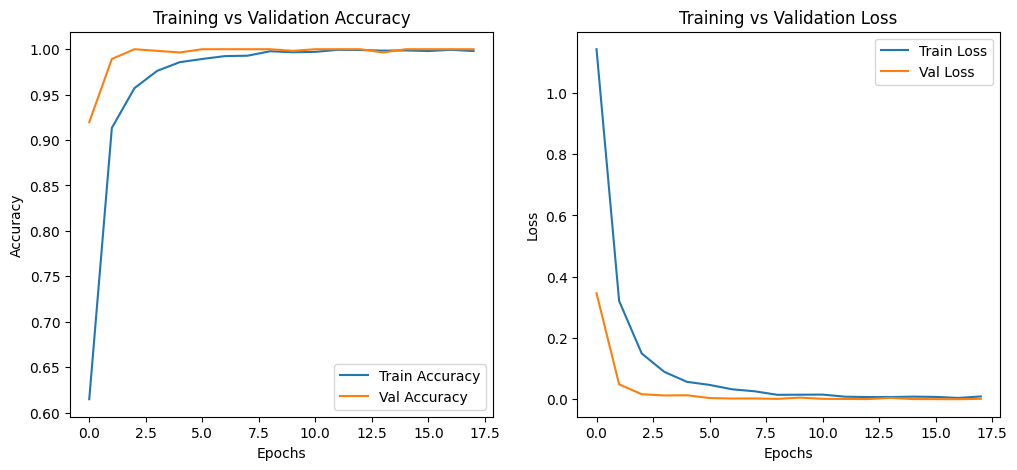

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


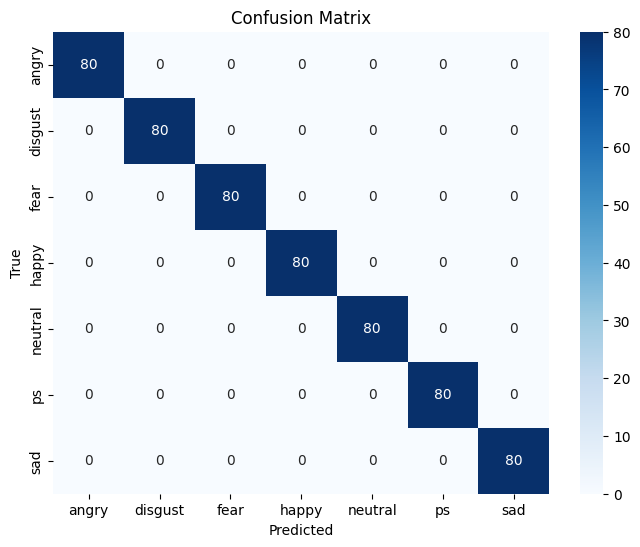

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


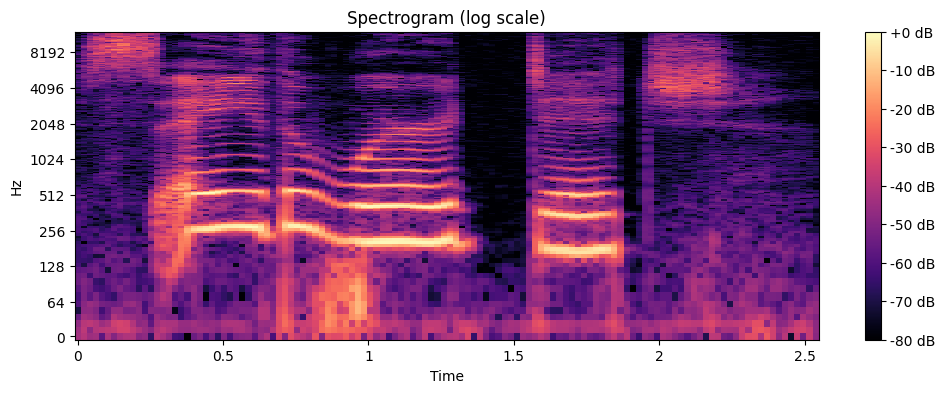

In [ ]:
import librosa.display

# Pick one raw audio sample from training
sample_audio = X_train_raw[0]
plt.figure(figsize=(12, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_audio)), ref=np.max)
librosa.display.specshow(D, sr=initial_sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (log scale)")
plt.show()


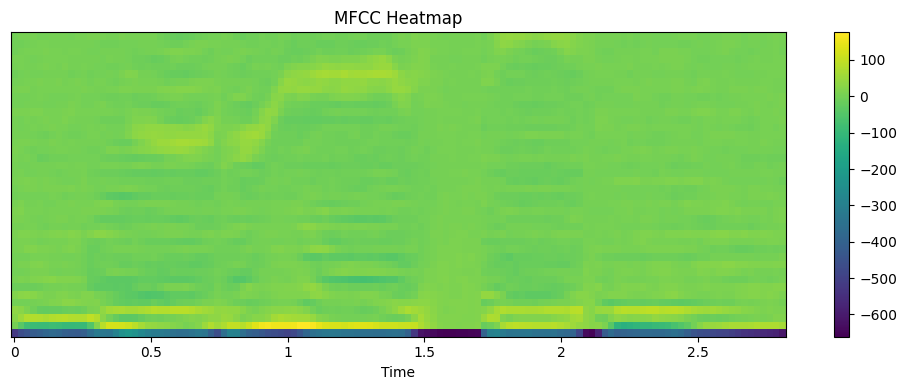

In [ ]:
# Extract MFCC for visualization
mfcc = librosa.feature.mfcc(y=sample_audio, sr=initial_sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title("MFCC Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
# Get the final training accuracy from the 'history' object
final_training_accuracy = history.history['accuracy'][-1] * 100
print(f"Final Training Accuracy: {final_training_accuracy:.2f}%")

Final Training Accuracy: 99.80%


Now that the data is processed and split, you can run the next cell to build and train the model.